In [1]:
# Set some environment variables
import os
gpu_num = 0 # GPU to be used. Use "" to use the CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress some TF warnings
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    os.system("pip install sionna")
    import sionna

# Configure GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
import warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

# Fix the seed for reproducible results
tf.random.set_seed(42)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

# For the implementation of the Keras models
from tensorflow.keras import Model
import scipy.special as sp

In [3]:
BATCH_SIZE = 100
NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 1

NUM_STREAMS_PER_TX = NUM_UT_ANT

NUM_BITS_PER_SYMBOL = 1
CODERATE = 1

# Number of coded bitsa
n = int(10000)
print(n)
# Number of information bits
k = int(n*CODERATE)
print(k)

10000
10000


In [4]:
class awgn(Model): # Inherits from Keras Model

    def __init__(self):
        super().__init__() # Must call the Keras model initializer

        n = 1000 # Number of coded bits
        k = int(n*CODERATE) # Number of information bits
        self.k = k

        # Define the BPSK constellation points
        bpsk_points = np.array([-1+0j, 1+0j], dtype=np.complex64)

        # Create a BPSK constellation with 1 bit per symbol and specify the initial values
        self.bpsk_constellation = sionna.mapping.Constellation(constellation_type="custom", 
                                   num_bits_per_symbol=1, 
                                   initial_value=bpsk_points)


        # The binary source will create batches of information bits
        self.binary_source = sionna.utils.BinarySource()


        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = sionna.mapping.Mapper(constellation_type="custom", 
                num_bits_per_symbol=1, 
                constellation=self.bpsk_constellation)

        # Frequency domain channel
        self.channel = sionna.channel.AWGN()
        
        # The demapper produces LLR for all coded bits
        self.demapper = sionna.mapping.Demapper(demapping_method="app",
                    constellation_type="custom",
                    num_bits_per_symbol=1,
                    hard_out = True,
                    constellation=self.bpsk_constellation)
        
        
    @tf.function # Graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        bits = self.binary_source([BATCH_SIZE, NUM_UT, NUM_STREAMS_PER_TX , k])
        print(bits.shape)

        # The mapper maps blocks of information bits to constellation symbols
        x = self.mapper(bits)
        print(x.shape)

        no = sionna.utils.ebnodb2no(ebno_db,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=CODERATE)


        # x is the channel input
        # no is the noise variance
        y = self.channel((x, no))
        print(y.shape)

        # The demapper produces LLR for all coded bits
        bits_hat = self.demapper([y , no])
        print(bits_hat.shape)

        return bits, bits_hat

(100, 1, 1, 10000)
(100, 1, 1, 10000)
(100, 1, 1, 10000)
(100, 1, 1, 10000)
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 1.5798e-01 | 1.0000e+00 |      157978 |     1000000 |          100 |         100 |         1.7 |reached target block errors
     -2.0 | 1.3055e-01 | 1.0000e+00 |      130550 |     1000000 |          100 |         100 |         0.1 |reached target block errors
     -1.0 | 1.0417e-01 | 1.0000e+00 |      104167 |     1000000 |          100 |         100 |         0.0 |reached target block errors
      0.0 | 7.8840e-02 | 1.0000e+00 |       78840 |     1000000 |          100 |         100 |         0.0 |reached target block errors
      1.0 | 5.5976e-02 | 1.0000e+00 |       55976 |     1000000 |          100 |         100 |         0.0 |reached target bl

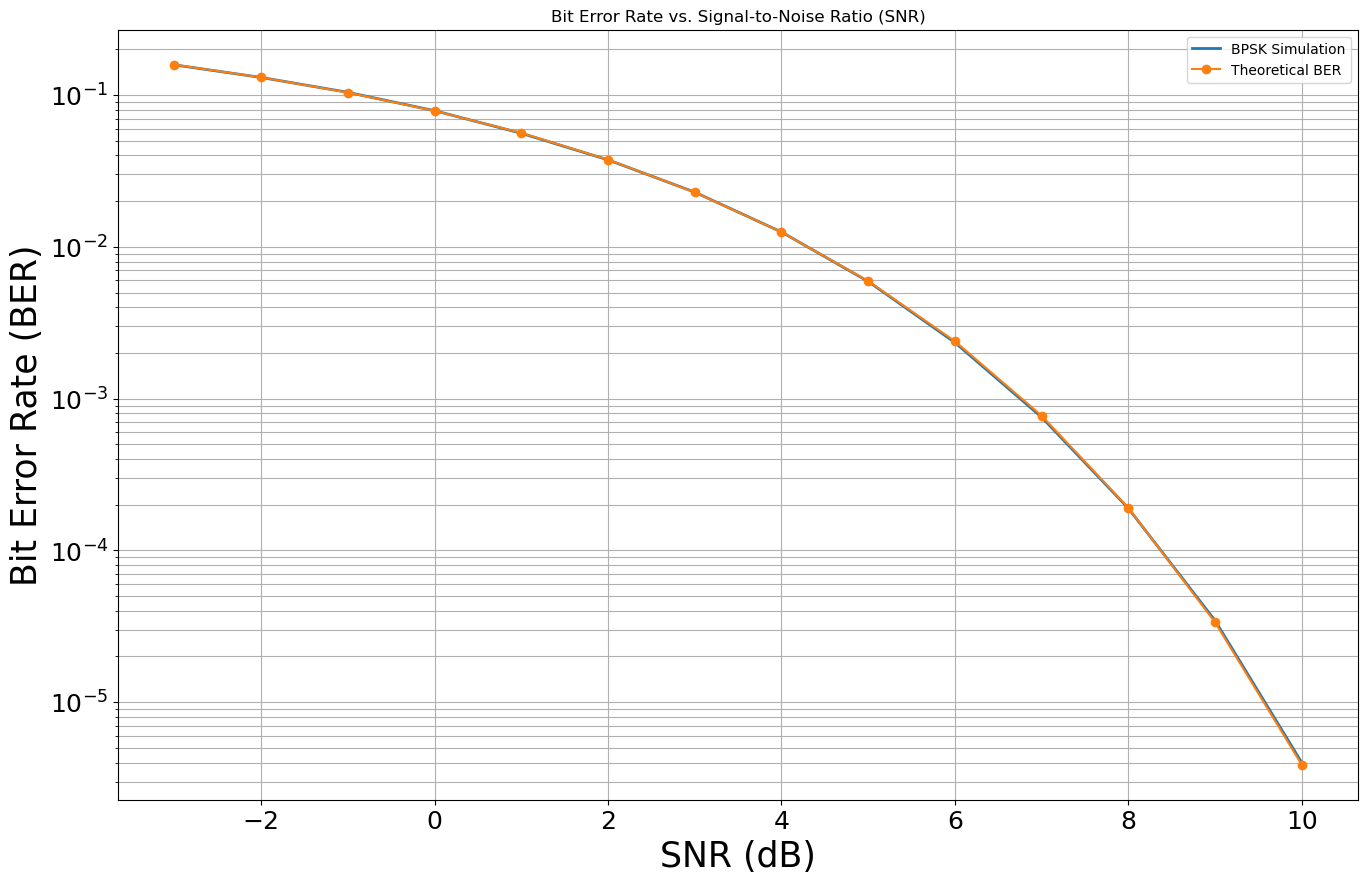

In [5]:
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10 # Maximum value of Eb/N0 [dB] for simulations

ber_plots = sionna.utils.PlotBER("AWGN")

model_ls = awgn()
ber_plots.simulate(model_ls,
                  ebno_dbs = np.arange(EBN0_DB_MIN, EBN0_DB_MAX + 1, 1),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="BPSK",
                  max_mc_iter=20, # run 10 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);

ber_plots();

snr_range_db = np.arange(-3, 11)  # Range from -3 dB to 10 dB
# Calculate theoretical BER
SNR = 10 ** (snr_range_db / 10)
BER_th = 0.5 * sp.erfc(np.sqrt(SNR))

# Plot theoretical BER curve
plt.semilogy(snr_range_db, BER_th, marker='o', label='Theoretical BER')

# Show the plot
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('Bit Error Rate vs. Signal-to-Noise Ratio (SNR)')
plt.grid(True)
plt.legend(["BPSK Simulation", "Theoretical BER"])
plt.show()

In [7]:
class awgn_1(Model): # Inherits from Keras Model

    def __init__(self):
        super().__init__() # Must call the Keras model initializer

        n = 1000 # Number of coded bits
        k = int(n*CODERATE) # Number of information bits
        self.k = k

        NUM_BITS_PER_SYMBOL = 4
        # The binary source will create batches of information bits
        self.binary_source = sionna.utils.BinarySource()

        self.constellation = sionna.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = sionna.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

        # Frequency domain channel
        self.channel = sionna.channel.AWGN()

        # The demapper produces LLR for all coded bits
        self.demapper = sionna.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL, hard_out=True)

        
    @tf.function # Graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        
        NUM_BITS_PER_SYMBOL = 4

        bits = self.binary_source([BATCH_SIZE, NUM_UT, NUM_STREAMS_PER_TX , k])
        print(bits.shape)
        
        
        # The mapper maps blocks of information bits to constellation symbols
        x = self.mapper(bits)
        print(x.shape)

        no = sionna.utils.ebnodb2no(ebno_db,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=CODERATE)

        # x is the channel input
        # no is the noise variance
        y = self.channel((x, no))
        print(y.shape)

        # The demapper produces LLR for all coded bits
        bits_hat = self.demapper([y , no])
        print(bits_hat.shape)

        return bits, bits_hat

(100, 1, 1, 10000)
(100, 1, 1, 2500)
(100, 1, 1, 2500)
(100, 1, 1, 10000)
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 2.1058e-01 | 1.0000e+00 |      210581 |     1000000 |          100 |         100 |         1.0 |reached target block errors
     -2.0 | 1.8715e-01 | 1.0000e+00 |      187154 |     1000000 |          100 |         100 |         0.1 |reached target block errors
     -1.0 | 1.6359e-01 | 1.0000e+00 |      163593 |     1000000 |          100 |         100 |         0.1 |reached target block errors
      0.0 | 1.4069e-01 | 1.0000e+00 |      140686 |     1000000 |          100 |         100 |         0.1 |reached target block errors
      1.0 | 1.1859e-01 | 1.0000e+00 |      118587 |     1000000 |          100 |         100 |         0.1 |reached target bloc

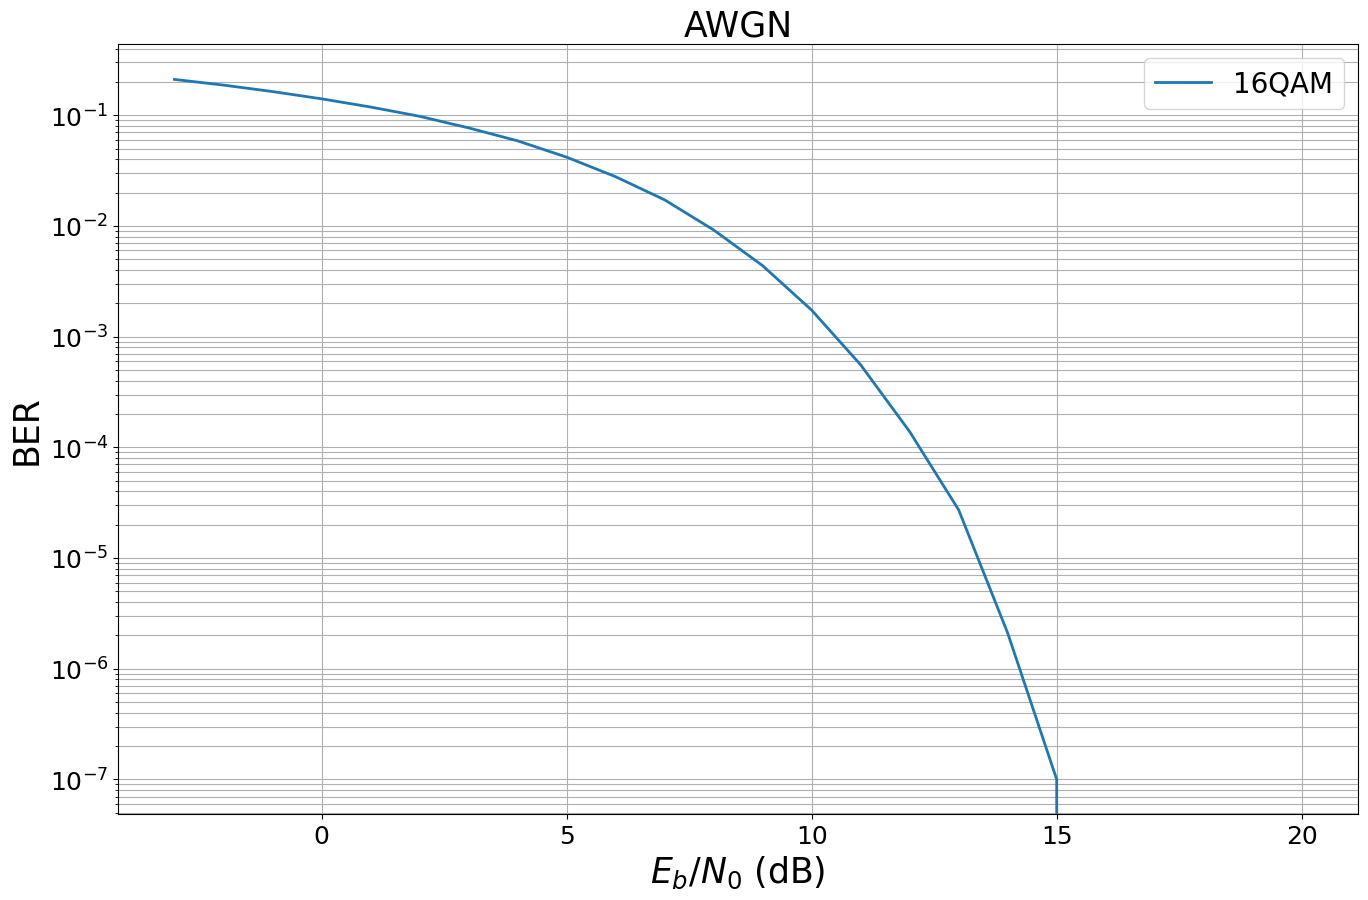

In [8]:
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 20 # Maximum value of Eb/N0 [dB] for simulations

ber_plots = sionna.utils.PlotBER("AWGN")

model_ls_1 = awgn_1()
ber_plots.simulate(model_ls_1,
                  ebno_dbs = np.arange(EBN0_DB_MIN, EBN0_DB_MAX + 1, 1),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="16QAM",
                  max_mc_iter=10, # run 10 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);

ber_plots();

In [8]:
# Number of coded bitsa
n = int(9600)
print(n)
# Number of information bits
k = int(n*CODERATE)
print(k)

9600
9600


In [9]:
class awgn_2(Model): # Inherits from Keras Model

    def __init__(self):
        super().__init__() # Must call the Keras model initializer

        n = 6000 # Number of coded bits
        k = int(n*CODERATE) # Number of information bits
        self.k = k

        NUM_BITS_PER_SYMBOL = 6
        # The binary source will create batches of information bits
        self.binary_source = sionna.utils.BinarySource()

        self.constellation = sionna.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = sionna.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

        # Frequency domain channel
        self.channel = sionna.channel.AWGN()

        # The demapper produces LLR for all coded bits
        self.demapper = sionna.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL, hard_out=True)

        
    @tf.function # Graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        
        NUM_BITS_PER_SYMBOL = 6

        bits = self.binary_source([BATCH_SIZE, NUM_UT, NUM_STREAMS_PER_TX , k])
        print(bits.shape)
        
        
        # The mapper maps blocks of information bits to constellation symbols
        x = self.mapper(bits)
        print(x.shape)

        no = sionna.utils.ebnodb2no(ebno_db,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=CODERATE)

        # x is the channel input
        # no is the noise variance
        y = self.channel((x, no))
        print(y.shape)

        # The demapper produces LLR for all coded bits
        bits_hat = self.demapper([y , no])
        print(bits_hat.shape)

        return bits, bits_hat

In [ ]:
model_ls_2 = awgn_2()

ber_plots.simulate(model_ls_2,
                  ebno_dbs=np.arange(EBN0_DB_MIN, EBN0_DB_MAX + 1, 1),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="64QAM",
                  soft_estimates=True,
                  max_mc_iter=10, # run 10 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);

ber_plots();

(100, 1, 1, 9600)
(100, 1, 1, 1600)
(100, 1, 1, 1600)
(100, 1, 1, 9600)
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 2.6485e-01 | 1.0000e+00 |      254259 |      960000 |          100 |         100 |         0.8 |reached target block errors
     -2.0 | 2.4411e-01 | 1.0000e+00 |      234346 |      960000 |          100 |         100 |         0.2 |reached target block errors
     -1.0 | 2.2118e-01 | 1.0000e+00 |      212328 |      960000 |          100 |         100 |         0.2 |reached target block errors
      0.0 | 1.9897e-01 | 1.0000e+00 |      191007 |      960000 |          100 |         100 |         0.2 |reached target block errors
      1.0 | 1.7727e-01 | 1.0000e+00 |      170175 |      960000 |          100 |         100 |         0.2 |reached target block 

In [ ]:
# Number of coded bitsa
n = int(9600)
print(n)
# Number of information bits
k = int(n*CODERATE)
print(k)

In [ ]:
class awgn_3(Model): # Inherits from Keras Model

    def __init__(self):
        super().__init__() # Must call the Keras model initializer

        self.k = k

        NUM_BITS_PER_SYMBOL = 8
        # The binary source will create batches of information bits
        self.binary_source = sionna.utils.BinarySource()

        self.constellation = sionna.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = sionna.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

        # Frequency domain channel
        self.channel = sionna.channel.AWGN()

        # The demapper produces LLR for all coded bits
        self.demapper = sionna.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL, hard_out=True)

        
    @tf.function # Graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        
        NUM_BITS_PER_SYMBOL = 8

        bits = self.binary_source([BATCH_SIZE, NUM_UT, NUM_STREAMS_PER_TX , k])
        print(bits.shape)
        
        
        # The mapper maps blocks of information bits to constellation symbols
        x = self.mapper(bits)
        print(x.shape)

        no = sionna.utils.ebnodb2no(ebno_db,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=CODERATE)

        # x is the channel input
        # no is the noise variance
        y = self.channel((x, no))
        print(y.shape)

        # The demapper produces LLR for all coded bits
        bits_hat = self.demapper([y , no])
        print(bits_hat.shape)

        return bits, bits_hat

In [ ]:
model_ls_3 = awgn_3()

ber_plots.simulate(model_ls_3,
                  ebno_dbs=np.arange(EBN0_DB_MIN, EBN0_DB_MAX + 1, 1),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="256QAM",
                  soft_estimates=True,
                  max_mc_iter=10, # run 10 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=True);

ber_plots();